Раскидывание данных для первого водителя по массивам:

In [158]:
%matplotlib inline
import pandas
import math
import matplotlib.pyplot as plt
import re
import datetime
import sort_coordinates

data = pandas.read_csv('data1.tsv', sep="\t")
debug = pandas.read_csv('debug1.tsv', sep="\t")
#debug[debug["hash"] == 86]
# names=['date', 'id', 'type', 'hash', 'latitude', 'longitude']
id_unique = data["id"].unique()
date_points = []
lat_points = []
lon_points = []

for i in id_unique:
    str_date = data[data["id"] == i]["date"].copy()
    datepstr = []
    format_date = "%Y-%m-%d %H:%M:%S"
    for s in str_date:
        search_date = re.search('(\d+-\d+-\d+\s\d+:\d+:\d+)', s)
        t = datetime.datetime.strptime(search_date.group(1), format_date)
        datepstr.append(t)
    date_points.append(datepstr)
    lat = sort_coordinates.del_invalid_idx(data[data["id"] == i]["latitude"].copy())
    lat_points.append(lat)
    lon = sort_coordinates.del_invalid_idx(data[data["id"] == i]["longitude"].copy())
    lon_points.append(lon)

In [159]:
min_eps = 10
max_eps = 0
eps = 0
idx_max = 0
jdx_max = 0
next_max_eps = 10
for j in range(len(lat_points) - 1):
    for i in range(len(lat_points[j]) - 2):
        
        max_eps = max(math.sqrt(math.pow(lat_points[j][i+1] - lat_points[j][i], 2)
                        + math.pow(lon_points[j][i+1] - lon_points[j][i], 2)), max_eps)
        
        min_eps = min(math.sqrt(math.pow(lat_points[j][i+1] - lat_points[j][i], 2)
                                + math.pow(lon_points[j][i+1] - lon_points[j][i], 2)), min_eps)
    q = next_max_eps
    next_max_eps = min(max_eps, next_max_eps)
    if (q < max_eps):
        idx_max = i
        jdx_max = j
    
print (min_eps, max_eps)

0.0 0.03393044821395047


In [3]:
start_points = []
f_points = []
next_points = 1
x = lat_points[0][0]
y = lon_points[0][0]
x_next = lat_points[0][next_points]
y_next = lon_points[0][next_points]
while (x + max_eps > x_next)and(y + max_eps > y_next)and(x - max_eps < x_next)and(y - max_eps < y_next):
    next_points += 1  
    f_points.append([lat_points[0][next_points], lon_points[0][next_points]])
    x_next = lat_points[0][next_points]
    y_next = lon_points[0][next_points]


id_points = len(lat_points[0]) - 1 - next_points
for i in range(id_points):
    x_next = lat_points[0][i+next_points]
    y_next = lon_points[0][i+next_points]
    if (x + max_eps > x_next)and(y + max_eps > y_next)and(x - max_eps < x_next)and(y - max_eps < y_next): 
        start_points.append([lat_points[0][i + next_points], lon_points[0][i + next_points]])   

Время так же важно. Между 1 и 2 временем значительно меньше времени, чем между 2 и 3. 
Соответственно нужно посмотреть на сколько большой/маленький отрезок пройден за время между точками. А значит нужно всё таки знать скорость.

In [106]:
speed = []
for j in range(len(lat_points) - 1):
    speed_hero = []
    for i in range(len(lat_points[j]) - 1):
        range_way = math.sqrt(math.pow(lat_points[j][i+1] - lat_points[j][i], 2)
                              + math.pow(lon_points[j][i+1] - lon_points[j][i], 2))
        range_time = (date_points[j][i + 1] - date_points[j][i]).total_seconds()
        speed_hero.append(range_way/range_time)
    speed.append(speed_hero)


349
350


In [110]:
import sort_coordinates

sort_speed = []

idx = 0

sort_lat = []
sort_lon = []
for i in range(len(speed)-1):
    temp_lat_points = sort_coordinates.del_invalid_idx(lat_points[i])
    temp_lon_points = sort_coordinates.del_invalid_idx(lon_points[i])
    lat = []
    lon = []
    sp = []
    temp_speed_array = speed[i].copy()
    while len(temp_speed_array) != 0:
        min_speed = 100000
        for i in range(len(temp_speed_array)-1):
            if min_speed > temp_speed_array[i]:
                min_speed = temp_speed_array[i]
                idx = i
        sp.append((idx, temp_speed_array.pop(idx)))
        lat.append((temp_lat_points.pop(idx), temp_lat_points[idx]))
        lon.append((temp_lon_points.pop(idx), temp_lon_points[idx]))
    sort_lat.append(lat)
    sort_lon.append(lon)
    sort_speed.append(sp)



Как отсортировать скорость сохраняя индекс вторым параметром?

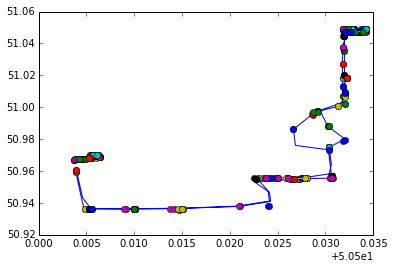

In [122]:

plt.plot(debug["latitude"], debug["longitude"], c = 'b')

for j in range(len(sort_speed)-1):
    ix = len(sort_lat[j])/15
    for i in range(int(ix)):
        plt.plot(sort_lat[j][i], sort_lon[j][i], c = 'y')
        plt.plot(sort_lat[j][i], sort_lon[j][i], 'o')

Нужно понять какая скорость максимальная для остановок, чтобы решить какое кол-во точек, где тормозит водитель брать. Плюс нельзя забывать о том, что их в любом случае должно быть значительно больше так как светафоры/пробки...

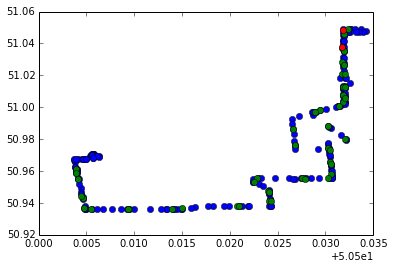

In [135]:
plt.plot(lat, lon, 'o')
plt.plot(debug["latitude"], debug["longitude"], 'o', c = 'g')
plt.plot(lat_points[jdx_max][idx_max+1], lon_points[jdx_max][idx_max+1], 'o', c = 'r')
plt.plot(lat_points[jdx_max][idx_max], lon_points[jdx_max][idx_max], 'o', c = 'r')

Нужно придумать как определять число остановок и предварительно разделить маршрут на 2 части - в одну и в другую сторону.

Можно основываясь на данных debug определить минимальную скорость для отрезка на котором находиться остановка.

Причём надо не индекс точки запоминать, а именно отрезки соединяющие эти точки.

In [133]:
у =  0
for i in range(len(lat_points[0]) - 2):
    y = max(math.sqrt(math.pow(lat_points[0][i+1] - lat_points[0][i], 2)
                        + math.pow(lon_points[0][i+1] - lon_points[0][i], 2)), y)
print(lat_points[0][2])

50.505928


Поиск первого круга:

In [177]:
f_lat_points = []
f_lon_points = []
s_lat_points = []
s_lon_points = []
ways_x = []
ways_y = []
f_point_x = [lat_points[0][0], lat_points[0][1], lat_points[0][2]]
f_point_y = [lon_points[0][0], lon_points[0][1], lon_points[0][2]]
for j in range(len(lat_points[0]) - 6):
    way_f = math.sqrt(math.pow(f_point_x[0] - lat_points[0][j+3], 2)
                      + math.pow(f_point_y[0] - lon_points[0][j+3], 2))
    way_s = math.sqrt(math.pow(f_point_x[1] - lat_points[0][j+4], 2)
                      + math.pow(f_point_y[1] - lon_points[0][j+4], 2))
    way_t = math.sqrt(math.pow(f_point_x[2] - lat_points[0][j+5], 2)
                      + math.pow(f_point_y[2] - lon_points[0][j+5], 2))
    if way_f < max_eps and  way_s < max_eps  and  way_t < max_eps:
        ways_x.append(lat_points[0][:j+2])
        ways_y.append(lon_points[0][:j+2])
        break
    
print("end")
            

end


Сравниваю расстояние между 3-мя стартовыми координатами и тремя следующими подраяд. Если max_eps > получаю конец круга.

7


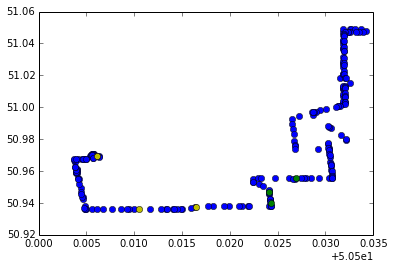

In [178]:
plt.plot(lat, lon, 'o')
print (len(ways_x[0]))
plt.plot(lat_points[0][0], lon_points[0][0], 'o', c = 'y')
plt.plot(lat_points[0][3], lon_points[0][3], 'o', c = 'y')
plt.plot(lat_points[0][5], lon_points[0][5], 'o', c = 'y')

plt.plot(lat_points[0][len(ways_x[0])], lon_points[0][len(ways_x[0])], 'o', c = 'g')
plt.plot(lat_points[0][len(ways_x[0])+1], lon_points[0][len(ways_x[0])+1], 'o', c = 'g')
plt.plot(lat_points[0][len(ways_x[0])+2], lon_points[0][len(ways_x[0])+2], 'o', c = 'g')

Где-то ошиблась.